In [1]:
running_on_colab = False

In [2]:
# Import drive and connect
if running_on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

#     import subprocess
#     subprocess.run("pip install pyrsgis", shell=True)
#     subprocess.run("pip install matplotlib_scalebar", shell=True)

    # Check GPU
    subprocess.run("nvidia-smi", shell=True)

In [3]:
! pip install tensorflow

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.model_selection import train_test_split

import dataUtils as diu
import plotEvalUtils as peu

import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  0
[]


In [12]:
# constants for program

input_bands = [i+1 for i in range(0,7)]
nBands = len(input_bands)
labels_band = 8

print('Analyzing bands: ', input_bands)
print('nBands: ', nBands)

downsampleMajority = False

diu.setGlobalVariables(input_bands, nBands)

if running_on_colab: image_base_path = "/content/drive/MyDrive/MangroveClassification/"
else: image_base_path = "./data/sentinal/"

loadModel = True

Analyzing bands:  [1, 2, 3, 4, 5, 6, 7]
nBands:  7


In [13]:
# generate training data from chosen images
training_images = []

training_images.append(image_base_path + "krishna_1_2022.tif")
training_images.append(image_base_path + "krishna_2_2022.tif")
training_images.append(image_base_path + "krishna_3_2022.tif")
training_images.append(image_base_path + "krishna_4_2022.tif")
training_images.append(image_base_path + "krishna_5_2022.tif")

model_input_data, model_input_labels = diu.loadTrainingImages(training_images, downsampleMajority)
mask = model_input_labels != -1
model_input_labels = model_input_labels[mask]
model_input_data = model_input_data[mask] 
#get max of model_input_data and normalise using that
max_val = np.max(model_input_data)
model_input_data = model_input_data/max_val
print(model_input_data)

The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://py

In [14]:
print(model_input_labels)

[0. 0. 0. ... 0. 0. 0.]


In [15]:
print(model_input_data.shape)

(2137355, 7)


In [16]:
# split the data
xTrain, xTest, yTrain, yTest = train_test_split(model_input_data, model_input_labels, test_size=0.2, random_state=42, stratify=model_input_labels, shuffle=True)

# reshape it as an additional step for input into the NN
xTrain = xTrain.reshape((xTrain.shape[0], 1, nBands))
xTest = xTest.reshape((xTest.shape[0], 1, nBands))

print(xTrain.shape)
print(xTest.shape)

(1709884, 1, 7)
(427471, 1, 7)


In [17]:
model = keras.Sequential([
      keras.layers.Flatten(input_shape=(1, nBands)),
      keras.layers.Dense(14, activation='relu'),
      keras.layers.Dense(14, activation='relu'),
      keras.layers.Dense(2, activation='softmax')])


sample_weight = np.ones(shape=(len(yTrain),))
sample_weight[yTrain == -1] = 0

# Create a Dataset that includes sample weights
# (3rd element in the return tuple).
train_dataset = tf.data.Dataset.from_tensor_slices((xTrain, yTrain, sample_weight))

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(train_dataset, epochs=10)

print(model.summary())

Epoch 1/10
26717/26717 [==============================] - 20s 738us/step - loss: 0.3735 - accuracy: 0.8297
Epoch 2/10
26717/26717 [==============================] - 19s 698us/step - loss: 0.3612 - accuracy: 0.8375
Epoch 3/10
26717/26717 [==============================] - 18s 656us/step - loss: 0.3569 - accuracy: 0.8399
Epoch 4/10
26717/26717 [==============================] - 21s 790us/step - loss: 0.3549 - accuracy: 0.8408
Epoch 5/10
26717/26717 [==============================] - 19s 718us/step - loss: 0.3537 - accuracy: 0.8413
Epoch 6/10
26717/26717 [==============================] - 18s 667us/step - loss: 0.3528 - accuracy: 0.8419
Epoch 7/10
26717/26717 [==============================] - 21s 804us/step - loss: 0.3521 - accuracy: 0.8423
Epoch 8/10
26717/26717 [==============================] - 18s 687us/step - loss: 0.3514 - accuracy: 0.8427
Epoch 9/10
26717/26717 [==============================] - 18s 679us/step - loss: 0.3509 - accuracy: 0.8429
Epoch 10/10
26717/26717 [============

In [18]:
# Predict for test data
yTest_pred_prob = model.predict(xTest)
yTest_pred_prob = yTest_pred_prob[:,1] # grab probablities for class label 1

peu.printClassificationMetrics(yTest, yTest_pred_prob)

13359/13359 [==============================] - 7s 502us/step
Confusion matrix:
 [[282627  31539]
 [ 35271  78034]]

P-Score: 0.712, R-Score: 0.689
Accuracy: 0.844
f1: 0.700
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89    314166
         1.0       0.71      0.69      0.70    113305

    accuracy                           0.84    427471
   macro avg       0.80      0.79      0.80    427471
weighted avg       0.84      0.84      0.84    427471



0.7002395929611717

In [169]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
kSize = 7
stride = 1

In [170]:
model_input_data, model_input_labels = diu.loadTrainingImagesCNN(training_images, downsampleMajority, kSize, stride)
xTrain, xTest, yTrain, yTest = train_test_split(model_input_data, model_input_labels, test_size=0.4, random_state=42, stratify=model_input_labels, shuffle=True)

Processing image:  0
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
Using training data of length:  807408
Class 0: 688738 Class 1: 118670
Class 0:  85.3% Class 1:  14.7%


In [171]:
model = keras.Sequential()
model.add(Conv2D(32, kernel_size=3, padding='valid', activation='relu', input_shape=(kSize, kSize, nBands)))
model.add(Dropout(0.25))
model.add(Conv2D(48, kernel_size=3, padding='valid', activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

# Define the accuracy metrics and parameters
model.compile(optimizer= 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

# fit the model
history = model.fit(xTrain, yTrain, validation_split=0.3, epochs=10)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 5, 5, 32)          2048      
                                                                 
 dropout_3 (Dropout)         (None, 5, 5, 32)          0         
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 3, 48)          13872     
                                                                 
 dropout_4 (Dropout)         (None, 3, 3, 48)          0         
                                                                 
 flatten_9 (Flatten)         (None, 432)               0         
                                                                 
 dense_26 (Dense)            (None, 64)                27712     
                                                                 
 dropout_5 (Dropout)         (None, 64)               

In [172]:
# Predict for test data
yTest_pred_prob = model.predict(xTest)
yTest_pred_prob = yTest_pred_prob[:,1] # grab probablities for class label 1

f1_score = peu.printClassificationMetrics(yTest, yTest_pred_prob)

10093/10093 [==============================] - 8s 743us/step
Confusion matrix:
 [[266056   9440]
 [ 16268  31200]]

P-Score: 0.768, R-Score: 0.657
Accuracy: 0.920
f1: 0.708
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95    275496
         1.0       0.77      0.66      0.71     47468

    accuracy                           0.92    322964
   macro avg       0.86      0.81      0.83    322964
weighted avg       0.92      0.92      0.92    322964



In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier

In [20]:
training_images = []

training_images.append(image_base_path + "krishna_1_2022.tif")
training_images.append(image_base_path + "krishna_2_2022.tif")
training_images.append(image_base_path + "krishna_3_2022.tif")
training_images.append(image_base_path + "krishna_4_2022.tif")
training_images.append(image_base_path + "krishna_5_2022.tif")

model_input_data, model_input_labels = diu.loadTrainingImages(training_images, downsampleMajority)
mask = model_input_labels != -1
model_input_labels = model_input_labels[mask]
model_input_data = model_input_data[mask] 

The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://py

In [21]:
mlp_classifier = MLPClassifier(max_iter=1000, random_state=42)
gbc_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)

In [22]:
xTrain, xTest, yTrain, yTest = train_test_split(model_input_data, model_input_labels, test_size=0.4, random_state=42, stratify=model_input_labels, shuffle=True)

xTrain = xTrain.reshape((xTrain.shape[0], nBands))
xTest = xTest.reshape((xTest.shape[0], nBands))

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(xTrain, yTrain)

yPred = rf_classifier.predict(xTest)

accuracy = accuracy_score(yTest, yPred)
print(accuracy)

0.8584453682238093


In [23]:
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

gb_classifier.fit(xTrain, yTrain)
yPred = gb_classifier.predict(xTest)

accuracy = accuracy_score(yTest, yPred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(yTest, yPred))

Accuracy: 0.84
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.90      0.89    628332
         1.0       0.71      0.67      0.69    226610

    accuracy                           0.84    854942
   macro avg       0.80      0.79      0.79    854942
weighted avg       0.84      0.84      0.84    854942



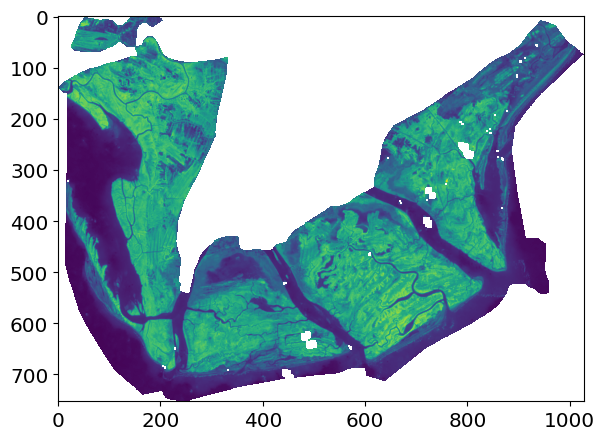

In [146]:
import rasterio
import matplotlib.pyplot as plt

# Specify the path to your GeoTIFF file
geotiff_path = './data/krishna2022-12-20.tif'

# Open the GeoTIFF file with rasterio
with rasterio.open(geotiff_path) as src:
    # Read the image data
    img = src.read(1)

plt.imshow(img)

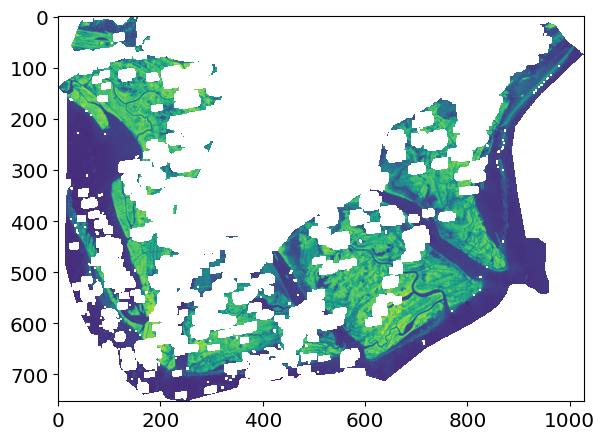

In [147]:
import rasterio
import matplotlib.pyplot as plt

# Specify the path to your GeoTIFF file
geotiff_path = './data/krishna2022-07-29.tif'

# Open the GeoTIFF file with rasterio
with rasterio.open(geotiff_path) as src:
    # Read the image data
    img = src.read(1)

plt.imshow(img)

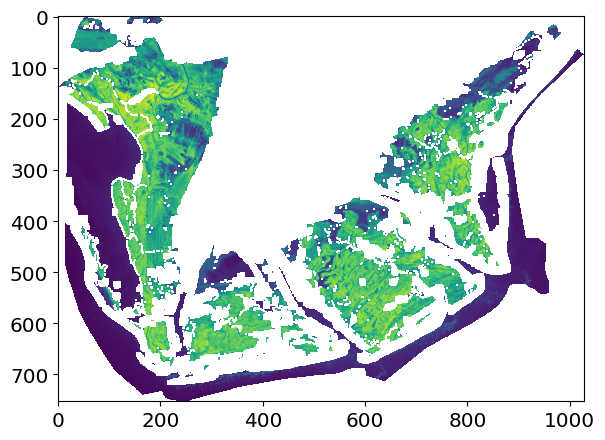

In [148]:
import rasterio
import matplotlib.pyplot as plt

# Specify the path to your GeoTIFF file
geotiff_path = './data/krishna2022-05-26.tif'

# Open the GeoTIFF file with rasterio
with rasterio.open(geotiff_path) as src:
    # Read the image data
    img = src.read(1)

plt.imshow(img)

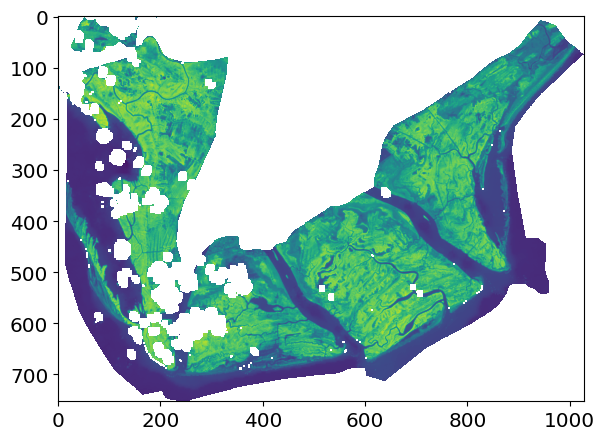

In [149]:
import rasterio
import matplotlib.pyplot as plt

# Specify the path to your GeoTIFF file
geotiff_path = './data/krishna2022-02-19.tif'

# Open the GeoTIFF file with rasterio
with rasterio.open(geotiff_path) as src:
    # Read the image data
    img = src.read(1)

plt.imshow(img)

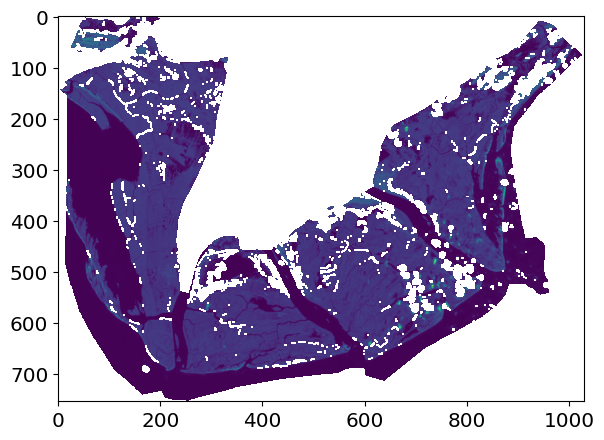

In [172]:
import rasterio
import matplotlib.pyplot as plt

# Specify the path to your GeoTIFF file
geotiff_path = './data/sentinal/krishna1.tif'

# Open the GeoTIFF file with rasterio
with rasterio.open(geotiff_path) as src:
    # Read the image data
    img = src.read(1)

plt.imshow(img)

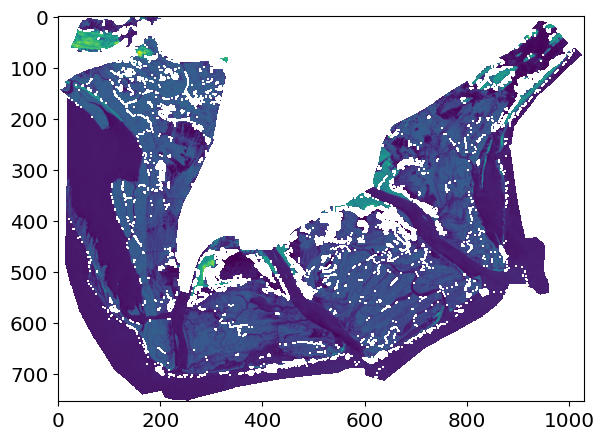

In [173]:
import rasterio
import matplotlib.pyplot as plt

# Specify the path to your GeoTIFF file
geotiff_path = './data/sentinal/krishna2.tif'

# Open the GeoTIFF file with rasterio
with rasterio.open(geotiff_path) as src:
    # Read the image data
    img = src.read(1)

plt.imshow(img)

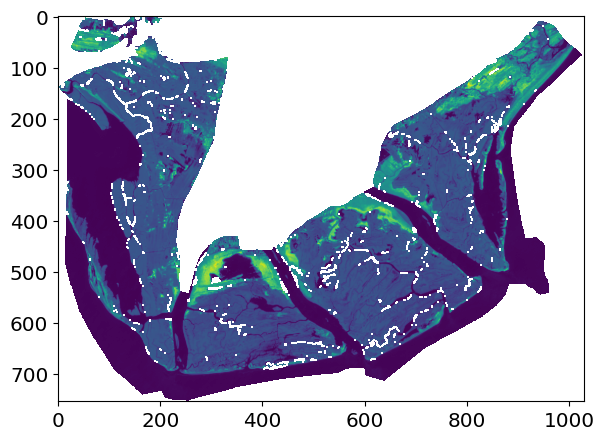

In [174]:
import rasterio
import matplotlib.pyplot as plt

# Specify the path to your GeoTIFF file
geotiff_path = './data/sentinal/krishna3.tif'

# Open the GeoTIFF file with rasterio
with rasterio.open(geotiff_path) as src:
    # Read the image data
    img = src.read(1)

plt.imshow(img)

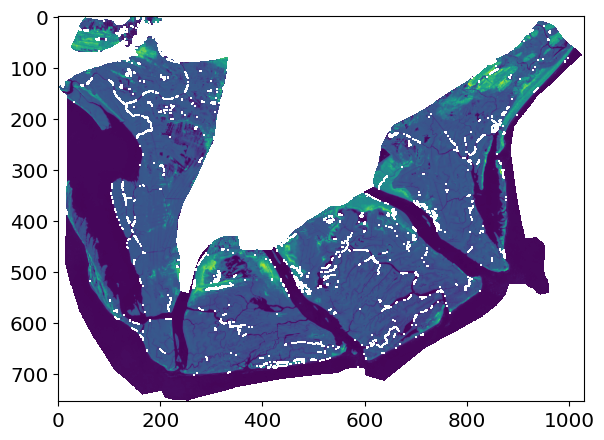

In [175]:
import rasterio
import matplotlib.pyplot as plt

# Specify the path to your GeoTIFF file
geotiff_path = './data/sentinal/krishna4.tif'

# Open the GeoTIFF file with rasterio
with rasterio.open(geotiff_path) as src:
    # Read the image data
    img = src.read(1)

plt.imshow(img)

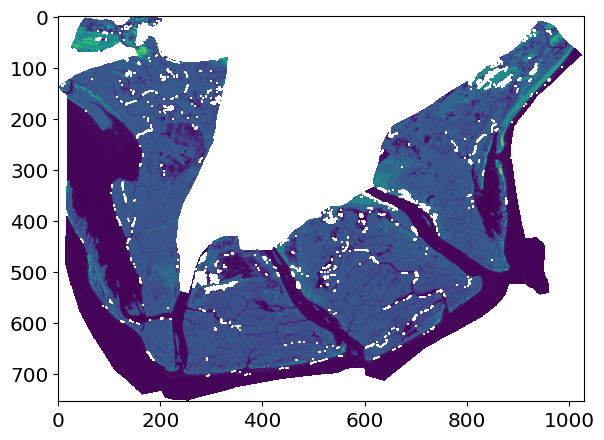

In [176]:
import rasterio
import matplotlib.pyplot as plt

# Specify the path to your GeoTIFF file
geotiff_path = './data/sentinal/krishna5.tif'

# Open the GeoTIFF file with rasterio
with rasterio.open(geotiff_path) as src:
    # Read the image data
    img = src.read(1)

plt.imshow(img)